# <center> IoT Dispenser Product Analysis </center>



<a id="1"></a>
### 1. About the dataset

>Essity has different kinds of sensors in its products at installed locations.  They track and store data, for example, how full or empty a dispenser is.  There are about 500 – 600 buildings with these types of connected products, including some airports.

> This dataset includes 15 largest customers for 1 year, Jan. 2019 – Jan. 2020.

> Some big customers have more than 100 sensors and/or more than 1000 units.  Mostly airports, amusement parks, large office buildings, etc.


In [1]:
from google.colab import drive
import os
import pandas as pd
from tqdm import tqdm
import datetime
import re
import numpy as np
from random import sample
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

<a id = "3"></a>
### 2. Importing Data

In [2]:
drive.mount('/content/drive')
os.listdir('/content/drive/MyDrive/Data')

Mounted at /content/drive


['finishedtasks.csv',
 'refillassortment.csv',
 'scu_log.csv',
 'locations.csv',
 'plans.csv',
 'planlocations.csv',
 'dispensers.csv',
 'sites.csv',
 'sitedefaultrefills.csv',
 'users.csv',
 'vru_log.csv']

In [3]:
base_dir = '/content/drive/MyDrive/Data'
files = os.listdir(base_dir)
files_dic = {}
for file in tqdm(files):
  name = file.split('.')[0]
  file_dir = base_dir + '/' + file
  df_name = name + '_df'
  files_dic[df_name] = pd.read_csv(file_dir,error_bad_lines=False,sep = ';')

100%|██████████| 11/11 [00:34<00:00,  3.12s/it]


In [4]:
sites = files_dic['sites_df']
locations = files_dic['locations_df']
dispensers = files_dic['dispensers_df']
plans = files_dic['plans_df']
planlocations = files_dic['planlocations_df']
finishedtasks = files_dic['finishedtasks_df']
users = files_dic['users_df']
sitedefaultrefills = files_dic['sitedefaultrefills_df']
refillassortment = files_dic['refillassortment_df']
vru = files_dic['vru_log_df']
scu = files_dic['scu_log_df']

##EDA

### EDA of dispensers, scu, vru, and finishedtasks dataframe

> Since we choose to analyze the product insight, dispensers, scu, vru, and finishedtasks dataframes are the table needed.

In [ ]:
#installation
!pip install folium
# Create a world map to show distributions of users 
import folium
from folium.plugins import MarkerCluster
#empty map
world_map= folium.Map(tiles='openstreetmap')
marker_cluster = MarkerCluster().add_to(world_map)

In [ ]:
site_cleaned = sites.drop(columns=['SiteName', 'CreatedAt', 'UpdatedAt', 'SubscriptionName', 'SubscriptionStart', 'SubscriptionEnd', \
                   'SubscriptionIsActive', 'SubscriptionProductCode', 'SubscriptionProductName', 'SubscriptionProductDescription'], inplace=False)
CountryName = ['Germany', 'Sweden', 'Sweden', 'Sweden', 'Switzerland', 'Netherlands', 'Sweden', 'Norway', 'Switzerland', \
               'United Kingdom', 'Denmark', 'Norway', 'Singapore', 'United Kingdom', 'Singapore']
site_cleaned['CountryName'] = CountryName

#### Find missing values

In [ ]:
#### Find missing values
missing_data = pd.DataFrame({'total_missing': dispensers.isnull().sum(), 'perc_missing': (dispensers.isnull().sum()/len(dispensers))*100})
missing_data

,total_missing,perc_missing
DispenserId,0,0.000000
LocationId,0,0.000000
DispenserArticleNumber,0,0.000000
IsProvisioned,0,0.000000
CreatedAt,0,0.000000
DispenserType,0,0.000000
NumberOfSensors,0,0.000000
ProductName,0,0.000000
RefillArticleNumber,739,15.834583


In [ ]:
missing_data = pd.DataFrame({'total_missing': scu.isnull().sum(), 'perc_missing': (scu.isnull().sum()/len(scu))*100})
missing_data

,total_missing,perc_missing
scu_id,0,0.0
timestamp,0,0.0
manufacture_year,0,0.0
sensor1,0,0.0
sensor2,0,0.0
gen_counter,0,0.0
batterylevel,0,0.0
signal_quality,0,0.0
signal_strength,0,0.0
software_version,0,0.0


In [ ]:
missing_data = pd.DataFrame({'total_missing': vru.isnull().sum(), 'perc_missing': (vru.isnull().sum()/len(vru))*100})
missing_data

,total_missing,perc_missing
intcnt,0,0.0
id,0,0.0
vru_id,0,0.0
manufacture_year,0,0.0
timestamp,0,0.0
counter_in,0,0.0
counter_out,0,0.0
batterylevel,0,0.0
signal_quality,0,0.0
signal_strength,0,0.0


In [ ]:
missing_data = pd.DataFrame({'total_mising' : finishedtasks.isnull().sum(), 'perc_missing': (finishedtasks.isnull().sum()/len(finishedtasks)*100)})
missing_data

,total_mising,perc_missing
CleaningRoundId,0,0.000000
PlanId,0,0.000000
CleaningMode,0,0.000000
CleaningRoundStartedAt,0,0.000000
CleaningRoundCompletedAt,9250,0.605737
LocationId,0,0.000000
TaskCompleted,0,0.000000
QualityAssessment,1192066,78.062507


Luckily, there is no missing value in the key parameters.
#### Find number of different type of products/dispensers using dispensers dataframe

Text(0.5, 1.0, 'Total Number of Products Used In All Sites')

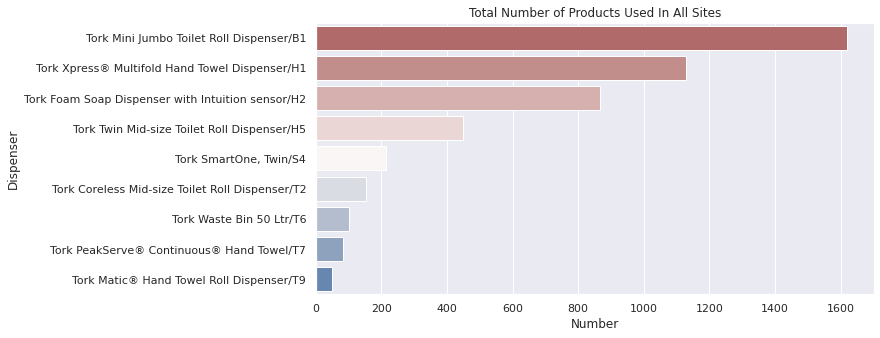

In [ ]:
df = dispensers.groupby("ProductName")["DispenserType"].count().reset_index()
df.columns=["ProductName", "Number"]
df = df.sort_values(by = "Number", ascending=False)
aab= dispensers.groupby("DispenserType")["ProductName"].count().reset_index()
aab.sort_values(by = "ProductName", ascending=False)
name = df["ProductName"].tolist()
type1 = aab["DispenserType"].tolist()
DispenserName = []
number = df.Number.tolist()
for i in range(len(name)):
  new = name[i]+"/"+type1[i]
  DispenserName.append(new)
df = pd.DataFrame({"Dispenser": DispenserName, "Number":number})
sns.set()
plt.figure(figsize=(10,5))
x_vals = df["Dispenser"]
y_vals = df["Number"]
sns.barplot(x=y_vals, y=x_vals, palette='vlag_r')
plt.title("Total Number of Products Used In All Sites")

## Average Lag Time Analysis
This part analyzed the average lag time to refill each type of dispensers in different sites.


In [ ]:
df = dispensers.merge(locations[["LocationId","SiteId"]], on = "LocationId")
df = df[["DispenserId", "SiteId","LocationId", "DispenserType"]]
scu_action = scu.merge(df, how = "inner", on = "DispenserId")
scu_action.head()

,scu_id,timestamp,manufacture_year,sensor1,sensor2,gen_counter,batterylevel,signal_quality,signal_strength,software_version,DispenserId,intervall,empty_level,full_level,hysteresis,linked_scu_id,linked_scu_manufacture_year,link_pos,dispenser_type,scuStatus,SiteId,LocationId,DispenserType
0,9617,2019-01-01 00:00:01.0000000,10,1347,64,0,2970,255,67,6,2892,30,700,250,50,0,0,0,T2TwinB,Green,9,1641,T2
1,9617,2019-01-02 00:00:00.0000000,10,1346,64,0,2970,255,67,6,2892,30,700,250,50,0,0,0,T2TwinB,Green,9,1641,T2
2,9617,2019-01-02 23:59:59.0000000,10,1340,64,0,2970,255,69,6,2892,30,700,250,50,0,0,0,T2TwinB,Green,9,1641,T2
3,9617,2019-01-03 07:39:57.0000000,10,62,184,0,2970,255,74,6,2892,30,700,250,50,0,0,0,T2TwinB,Red,9,1641,T2
4,9617,2019-01-03 23:59:58.0000000,10,62,214,0,2980,255,76,6,2892,30,700,250,50,0,0,0,T2TwinB,Red,9,1641,T2


In [ ]:
scu_action = scu_action[["timestamp","scu_id","DispenserId", "SiteId","LocationId", "DispenserType", "dispenser_type", 'scuStatus']]
scu_action['DateTime'] = pd.to_datetime(scu_action['timestamp'])
scu_action = scu_action.replace('Yellow', 'Red')

In [ ]:
def avg_lag(scuStatus, DateTime):
  """Calculate the avg lag for one scu"""
  i = 1
  lags = []
  need = 0
  refill = 0
  while i < len(DateTime):
    if scuStatus[i-1] == 'Green' and scuStatus[i] == ('Red'):
      need = DateTime[i]
    if scuStatus[i-1] == ('Red') and scuStatus[i] == 'Green':
      refill = DateTime[i]
      if need != 0:
        lag = (refill-need).total_seconds()/3600
        lags.append(lag)
    i +=1
  return 0 if len(lags) == 0 else sum(lags)/len(lags)

In [ ]:
def site_lag(site_num):
  """Calculate the avg lag time of each site"""
  res = []
  cond1 = scu_action["SiteId"] == site_num
  site9 = scu_action[cond1]
  dptype = site9.DispenserType.unique()
  for i in range(0, len(dptype)):
    dff = site9[site9["DispenserType"] == dptype[i]]
    scus = dff["scu_id"].unique()
    avg = []
    for j in range(0, len(scus)):
      dfff = dff[dff["scu_id"] == scus[j]]
      scuStatus = dfff['scuStatus'].tolist()
      DateTime = dfff['DateTime'].tolist()
      a = avg_lag(scuStatus, DateTime)
      avg.append(a)
    res.append(avg)
  lag = [sum(x)/len(x) for x in res]
  site = [site_num for _ in range(len(dptype))]
  return pd.DataFrame({"SiteId": site, "DispenserType":dptype, "lag":lag})

In [ ]:
site200_lag = site_lag(200)
site2388_lag = site_lag(2388)
site32_lag = site_lag(32)
site23_lag = site_lag(23)
site2344_lag = site_lag(2344)
site2284_lag = site_lag(2284)
site111_lag = site_lag(111)
site192_lag = site_lag(192)
site28_lag = site_lag(28)
site176_lag = site_lag(176)
site190_lag = site_lag(190)
site165_lag = site_lag(165)
site2310_lag = site_lag(2310)
site9_lag = site_lag(9)

In [ ]:
site_lag_avg = [site2388_lag, site200_lag,  site2344_lag, site2284_lag, site111_lag, site192_lag, site176_lag, site190_lag, site2310_lag, site9_lag]
result1 = pd.concat(site_lag_avg)
site_lag_avg = [site23_lag, site32_lag, site28_lag, site165_lag]
result2 = pd.concat(site_lag_avg)

Text(0.5, 1.0, 'Average Lag Time of Each Dispenser in Each Site')

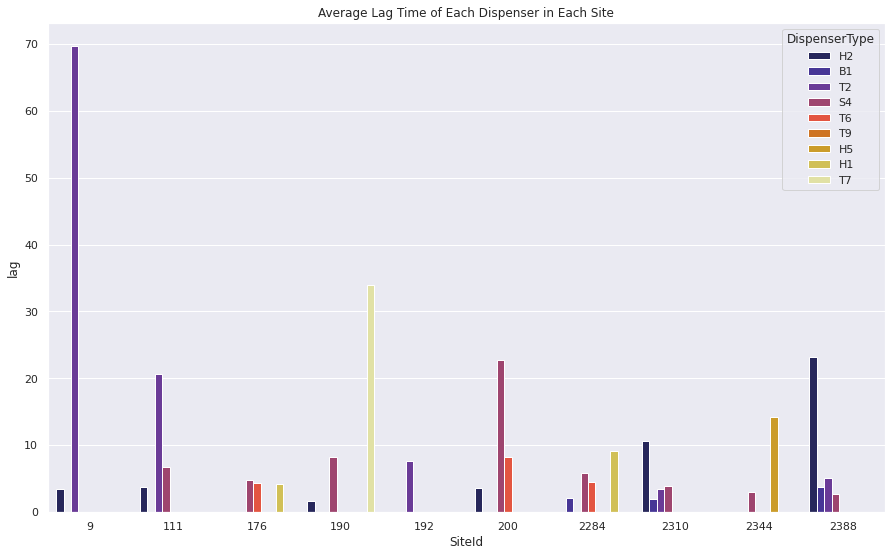

In [ ]:
sns.set()
plt.figure(figsize=(15,9))
sns.barplot(x="SiteId", y="lag", palette='CMRmap', hue="DispenserType",data = result1, dodge = True)
plt.title("Average Lag Time of Each Dispenser in Each Site")

Text(0.5, 1.0, 'Average Lag Time of Each Dispenser in Site Locates in Sweeden')

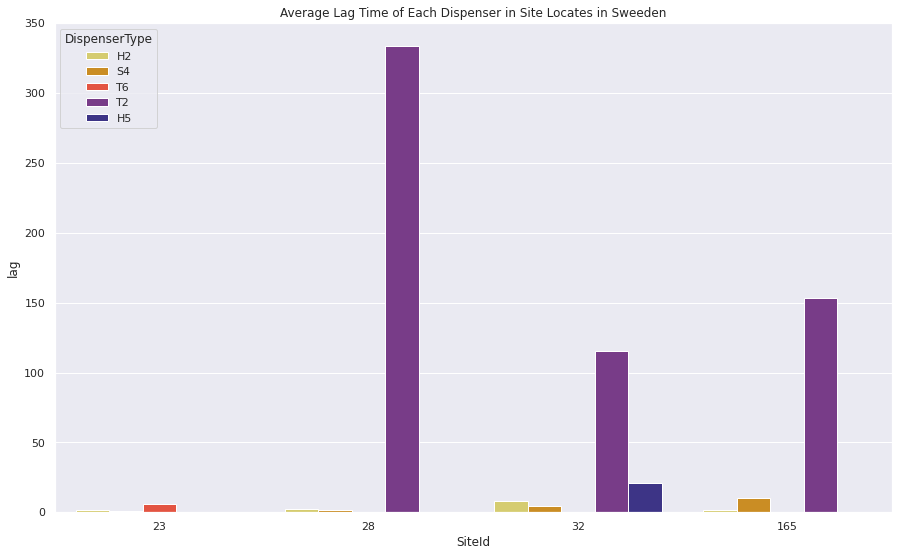

In [ ]:
sns.set()
plt.figure(figsize=(15,9))
sns.barplot(x="SiteId", y="lag", palette='CMRmap_r', hue="DispenserType",data = result2)
plt.title("Average Lag Time of Each Dispenser in Site Locates in Sweeden")

## Sensor data prediction

### Use one dispenser type at a particular location as an example

In [7]:
# dispensers' types
dispensers['DispenserType'].unique()

array(['T6', 'H2', 'T2', 'S4', 'H5', 'H1', 'B1', 'T7', 'T9'], dtype=object)

In [8]:
# dipenser with LocationId 234
# In model, treat dispenser type as a categorical variable

dispensers[dispensers['LocationId'] == 234]


,DispenserId,LocationId,DispenserArticleNumber,IsProvisioned,CreatedAt,DispenserType,NumberOfSensors,ProductName,RefillArticleNumber
2,484,234,650000,False,2015-11-19 18:21:40.4900000,H2,2,Tork Xpress® Multifold Hand Towel Dispenser,100289.0
13,512,234,651000,False,2015-11-19 18:21:40.6100000,T6,1,Tork Twin Mid-size Toilet Roll Dispenser,127530.0
306,1204,234,651600,False,2015-11-19 18:21:43.6930000,S4,1,Tork Foam Soap Dispenser with Intuition sensor,520701.0


### Find the peopleCounter sensor corresponding to that dispenser at that particular location

In [9]:
# Find PeopleCounterId at Location 234
# Note: One location has a unique PeopleCounter
locations = files_dic['locations_df']
locations[locations['LocationId'] == 234]

,LocationId,LocationName,SiteId,NodeLevel,NodePath,ParentNodePath,LowUrgencyThreshold,HighUrgencyThreshold,PeopleCounterId,PeopleCounterIsProvisioned,PeopleCounterCreatedAt
217,234,Location 234,23,3,/23/1/2/,/23/1/,30.0,40.0,1931.0,True,2015-12-11 13:11:29.8930000


### Get timestamp of the peopleCounter at that particular location

In [10]:
# Timestap of PeopleCounter No. 1931 at Location 234
vru = files_dic['vru_log_df']
vru_1931 = vru[vru['PeopleCounterId'] == 1931.0]

In [11]:
base_number = int(vru_1931.shift(1)[vru_1931['counter_in'].diff() < 0]['counter_in'].values[0])
index = vru_1931[vru_1931['counter_in'].diff() < 0].index[0]
sub_df = vru_1931.loc[index:].copy()
vru_1931.loc[index:]['counter_in'] = sub_df['counter_in'] + base_number

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Do the difference of count of people for each time stamp

In [12]:
diff = vru_1931['counter_in'].diff()
diff
vru_1931['diff'] = diff

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
vru_1931_new = vru_1931[vru_1931['diff'] >= 0]
# add previous one, then do difference

In [ ]:
import plotly.express as px
fig = px.line(vru_1931_new,x='timestamp',y='diff',title='peopleCounter No. 1931 at Location 234')
fig.update_xaxes(rangeslider_visible=True,rangeselector=dict(buttons=list([dict(count=1,label='1mon',step='month',stepmode='backward'),
                                                                           dict(count=2,label='2mon',step='month',stepmode='backward'),
                                                                           dict(step='all')])))
fig.show()

In [ ]:
vru_1931_new  = vru_1931_new.set_index(['timestamp'])

### Get timestamp of the dispenser(No.287) at that particular location

In [ ]:
def day_prior(x):
  x = x.split(' ')
  lst = [re.split('-|:',s) for s in x]
  lst_overall = lst[0] + lst[1]
  for i, e in enumerate(lst_overall):
    if e.startswith('0'):
      lst_overall[i] = e[1:] 
    if i == len(lst_overall) - 1:
      e = lst_overall[i]
      lst_overall[i] = e.split('.')[0]

  date = datetime.datetime(int(lst_overall[0]),int(lst_overall[1]),int(lst_overall[2]),
                         int(lst_overall[3]),int(lst_overall[4]),int(lst_overall[5]))
  date -= datetime.timedelta(days=1)
  time_str = date.strftime("%Y-%m-%d %H:%M:%S.%f0")

  return time_str

In [14]:
scu = files_dic['scu_log_df']
# timestamp for Dispenser No.287
scu_filter = scu[(scu['DispenserId'] == 484) | (scu['DispenserId'] == 512) | (scu['DispenserId'] == 1204)]
#scu_287 = scu_287.set_index(['timestamp'])

In [15]:
scu_filter_484 = scu_filter[scu_filter['DispenserId'] == 484]
scu_id = scu_filter_484['scu_id'].unique()
scu_filter_484_1 = scu_filter_484[scu_filter_484['scu_id'] == scu_id[0]]
scu_filter_484_2 = scu_filter_484[scu_filter_484['scu_id'] == scu_id[1]]


scu_filter_512 = scu_filter[scu_filter['DispenserId'] == 512]
scu_id = scu_filter_512['scu_id'].unique()
scu_filter_51_1 = scu_filter_512[scu_filter_512['scu_id'] == scu_id[0]]
scu_filter_51_2 = scu_filter_512[scu_filter_512['scu_id'] == scu_id[1]]
scu_filter_51_3 = scu_filter_512[scu_filter_512['scu_id'] == scu_id[2]]

scu_filter_1204 = scu_filter[scu_filter['DispenserId'] == 1204]
scu_id = scu_filter_1204['scu_id'].unique()
scu_filter_1204_1 = scu_filter_1204[scu_filter_1204['scu_id'] == scu_id[0]]
scu_filter_1204_2 = scu_filter_1204[scu_filter_1204['scu_id'] == scu_id[1]]

In [16]:
scu_filter = scu_filter[['sensor1','sensor2','dispenser_type','scuStatus']]

In [17]:
scu_filter = scu_filter.sample(frac=1).rename(columns={'scuStatus':'label'}).reset_index().drop(columns=['index']).drop_duplicates()

In [18]:
scu_filter['dispenser_type'] = scu_filter['dispenser_type'].apply(lambda x: 0 if x=='T6' else 1 if x=='H2' else 2)
scu_filter['label'] = scu_filter['label'].apply(lambda x: 0 if x=='Green' else 1 if x=='Yellow' else 2)
#data['label'] = data['label'].apply(lambda x: 0 if x=='Green' else 1)

### Random Forest and Neural Network

In [ ]:
train_size = int(len(scu_filter) * 0.70)
test_size = len(scu_filter) - train_size
train = scu_filter[:train_size]
test =  scu_filter[train_size:]
x_train = train.drop(columns=['label'])
x_test  = test.drop(columns=['label'])
y_train = train['label'].values
y_test = test['label'].values

In [ ]:

scaler_train = StandardScaler()
scaler_train.fit(x_train)
x_train_normalized = scaler_train.transform(x_train).copy()

scaler_test = StandardScaler()
scaler_test.fit(x_test)
x_test_normalized = scaler_test.transform(x_test).copy()

In [ ]:
clf1 = RandomForestClassifier(n_jobs=-1, random_state=5, n_estimators=50)
clf1.fit(x_train_normalized,y_train)
print(clf1.score(x_train_normalized,y_train))
print(clf1.score(x_test_normalized,y_test))
pred_rf = clf1.predict(x_test_normalized)

1.0
0.9987985582699239


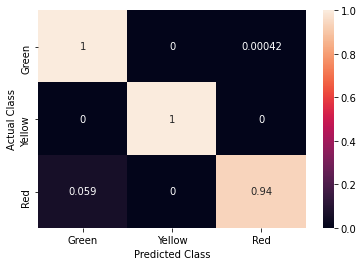

In [ ]:
final_array = sklearn.metrics.confusion_matrix(y_test, pred_rf)
final_array = pd.DataFrame(final_array, index=['Green','Yellow','Red'],columns=['Green','Yellow','Red'])
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_rf = sns.heatmap(final_array, annot=True)
plt_rf.set_xlabel('Predicted Class')
plt_rf.set_ylabel('Actual Class')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

print("confusion matrix (count):\n",confusion_matrix(y_test, pred_rf))

confusion matrix (count):
 [[2366    0    1]
 [   0   96    0]
 [   2    0   32]]


In [ ]:
TP = 47 
FP = 0
FN = 1
TN = 2449

#Recall : 0.75
recall = TP/(TP+FN)
print('Recall',recall)
#Specificity: 1
specificity = TN/(TN + FP)
print('Specificity',specificity)
#Precision: 1
precision = TP/(TP+FP)
print('Precision',precision)
# F1 score:
F1_score = 2*precision*recall / (precision + recall)
print('F1 score',F1_score)

Recall 0.9791666666666666
Specificity 1.0
Precision 1.0
F1 score 0.9894736842105264


In [ ]:
from sklearn.neural_network import MLPClassifier
clf_neural = MLPClassifier(verbose=1)
from sklearn.model_selection import GridSearchCV
para = {'activation': ['logistic','relu','identity'], 'hidden_layer_sizes':[(1024),(1024,256),(1024,256,64)],'max_iter':[50] }
cv = GridSearchCV(clf_neural, para, n_jobs = -1, cv = 3, verbose=1)
cv.fit(x_train_normalized, y_train)
cv.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.7min finished


Iteration 1, loss = 0.10518242
Iteration 2, loss = 0.00601219
Iteration 3, loss = 0.00507756
Iteration 4, loss = 0.00546218
Iteration 5, loss = 0.00535840
Iteration 6, loss = 0.00767031
Iteration 7, loss = 0.00510859
Iteration 8, loss = 0.00433931
Iteration 9, loss = 0.00441506
Iteration 10, loss = 0.00466617
Iteration 11, loss = 0.00378428
Iteration 12, loss = 0.00440124
Iteration 13, loss = 0.00465318
Iteration 14, loss = 0.00453895
Iteration 15, loss = 0.00486682
Iteration 16, loss = 0.00412029
Iteration 17, loss = 0.00379858
Iteration 18, loss = 0.00414799
Iteration 19, loss = 0.00491358
Iteration 20, loss = 0.00507262
Iteration 21, loss = 0.00387484
Iteration 22, loss = 0.00404629
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1024, 256), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=50,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [ ]:
cv.best_estimator_.fit(x_train_normalized, y_train)

Iteration 1, loss = 0.10103585
Iteration 2, loss = 0.00629089
Iteration 3, loss = 0.00567589
Iteration 4, loss = 0.00501176
Iteration 5, loss = 0.00463225
Iteration 6, loss = 0.00480224
Iteration 7, loss = 0.00393775
Iteration 8, loss = 0.00460728
Iteration 9, loss = 0.00440864
Iteration 10, loss = 0.00419026
Iteration 11, loss = 0.00540812
Iteration 12, loss = 0.00446434
Iteration 13, loss = 0.00449108
Iteration 14, loss = 0.00459173
Iteration 15, loss = 0.00482416
Iteration 16, loss = 0.00365310
Iteration 17, loss = 0.00487706
Iteration 18, loss = 0.00441507
Iteration 19, loss = 0.00552399
Iteration 20, loss = 0.00509835
Iteration 21, loss = 0.00423945
Iteration 22, loss = 0.00424787
Iteration 23, loss = 0.00413372
Iteration 24, loss = 0.00439029
Iteration 25, loss = 0.00410491
Iteration 26, loss = 0.00405034
Iteration 27, loss = 0.00358047
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1024, 256), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=50,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [ ]:
cv.score(x_test_normalized, y_test)

0.9891870244293152

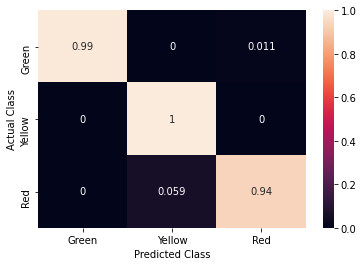

In [ ]:
 # test data confusion matrix
pred_nn = cv.predict(x_test_normalized)
final_array = sklearn.metrics.confusion_matrix(y_test, pred_nn)
final_array = pd.DataFrame(final_array, index=['Green','Yellow','Red'],columns=['Green','Yellow','Red'])
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_svm_test = sns.heatmap(final_array, annot=True)
plt_svm_test.set_xlabel('Predicted Class')
plt_svm_test.set_ylabel('Actual Class')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

print("confusion matrix (count):\n",confusion_matrix(y_test, pred_rf))

confusion matrix (count):
 [[2366    0    1]
 [   0   96    0]
 [   2    0   32]]


In [ ]:
TP = 47 
FP = 0
FN = 1
TN = 2449

#Recall : 0.75
recall = TP/(TP+FN)
print('Recall',recall)
#Specificity: 1
specificity = TN/(TN + FP)
print('Specificity',specificity)
#Precision: 1
precision = TP/(TP+FP)
print('Precision',precision)
# F1 score:
F1_score = 2*precision*recall / (precision + recall)
print('F1 score',F1_score)

Recall 0.9791666666666666
Specificity 1.0
Precision 1.0
F1 score 0.9894736842105264


### LSTM Network

In [19]:
import torch
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import timeit

In [20]:
class LSTM:
    # Initialize the class
    def __init__(self, X, Y, hidden_dim):
        
        # Check if there is a GPU available
        if torch.cuda.is_available() == True:
            self.dtype = torch.cuda.FloatTensor
        else:
            self.dtype = torch.FloatTensor
            
        # X has the form lags x data x dim
        # Y has the form data x dim

        # Define PyTorch variables
        self.X = torch.from_numpy(X).type(self.dtype)
        self.Y = torch.from_numpy(Y).type(self.dtype)
        #self.X = Variable(X, requires_grad=False)
        #self.Y = Variable(Y, requires_grad=False)
                 
        self.X_dim = X.shape[-1]
        self.Y_dim = Y.shape[-1]
        self.hidden_dim = hidden_dim
        self.lags = X.shape[0]
        
        # Initialize network weights and biases        
        self.U_f, self.b_f, self.W_f, self.U_i, self.b_i, self.W_i, self.U_s, self.b_s, self.W_s, self.U_o, self.b_o, self.W_o, self.V, self.c = self.initialize_RNN()
                
        # Store loss values
        self.training_loss = []
      
        # Define optimizer
        self.optimizer = torch.optim.Adam([self.U_f, self.b_f, self.W_f, self.U_i, self.b_i, self.W_i, self.U_s, self.b_s, self.W_s, self.U_o, self.b_o, self.W_o, self.V, self.c], lr=1e-3)
    
    
    # Initialize network weights and biases using Xavier initialization
    def initialize_RNN(self):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))
            return Variable(xavier_stddev*torch.randn(in_dim, out_dim).type(self.dtype), requires_grad=True)
        
        U_f = xavier_init(size=[self.X_dim, self.hidden_dim])
        U_i = xavier_init(size=[self.X_dim, self.hidden_dim])
        U_s = xavier_init(size=[self.X_dim, self.hidden_dim])
        U_o = xavier_init(size=[self.X_dim, self.hidden_dim])

        b_f = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True)
        b_i = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True)
        b_s = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True)
        b_o = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True)
            
        W_f = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)
        W_i = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)
        W_s = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)
        W_o = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)
        
        V = xavier_init(size=[self.hidden_dim, self.Y_dim])
        c = Variable(torch.zeros(1,self.Y_dim).type(self.dtype), requires_grad=True)
        
        return U_f, b_f, W_f,U_i, b_i, W_i,U_s, b_s, W_s,U_o, b_o, W_o, V, c
       
           
    # Evaluates the forward pass
    def forward_pass(self, X):
        H = torch.zeros(X.shape[1], self.hidden_dim).type(self.dtype)
        C_gate = torch.zeros(X.shape[1], self.hidden_dim).type(self.dtype)
        for i in range(0, self.lags):
          X_input = X[i,:,:]

          Forget_gate = torch.sigmoid(torch.matmul(H,self.W_f) + torch.matmul(X_input,self.U_f) + self.b_f)
          Input_gate = torch.sigmoid(torch.matmul(H,self.W_i) + torch.matmul(X_input,self.U_i) + self.b_i)
          Candidate_gate = torch.tanh(torch.matmul(H,self.W_s) + torch.matmul(X_input,self.U_s) + self.b_s)
          C_gate = Forget_gate * C_gate + Input_gate * Candidate_gate
          Output_gate = torch.sigmoid(torch.matmul(H,self.W_o) + torch.matmul(X_input,self.U_o) + self.b_o)
          H = Output_gate * torch.tanh(C_gate)

        H = torch.matmul(H,self.V) + self.c



        return H
  

    # Computes the mean square error loss
    def compute_loss(self, X, Y):
        loss = torch.mean((Y - self.forward_pass(X))**2)
        return loss
        
    # Fetches a mini-batch of data
    def fetch_minibatch(self,X, y, N_batch):
        N = X.shape[1]
        idx = torch.randperm(N)[0:N_batch]
        X_batch = X[:,idx,:]
        y_batch = y[idx,:]      
        return X_batch, y_batch
    
    
    # Trains the model by minimizing the MSE loss
    def train(self, nIter = 30000, batch_size = 256):
        
        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch mini-batch
            X_batch, Y_batch = self.fetch_minibatch(self.X, self.Y, batch_size)
            
            loss = self.compute_loss(X_batch, Y_batch)
            
            # Store loss value
            self.training_loss.append(loss)
            
            # Backward pass
            loss.backward()
            
            # update parameters
            self.optimizer.step()
            
            # Reset gradients for next step
            self.optimizer.zero_grad()
            
            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss.cpu().data.numpy(), elapsed))
                start_time = timeit.default_timer()
    
    
   # Evaluates predictions at test points    
    def predict(self, X_star):
        X_star = torch.from_numpy(X_star).type(self.dtype)
        y_star = self.forward_pass(X_star)
        y_star = y_star.cpu().data.numpy()
        return y_star

In [21]:
new_df = scu_filter_51_1[['sensor1','sensor2','scuStatus']]
new_df['scuStatus'] = new_df['scuStatus'].apply(lambda x: 0 if x=='Green' else 1 if x=='Yellow' else 2)
data = new_df[['sensor1','sensor2']].to_numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
def create_dataset(data, lags):
    N = len(data)-lags
    data_dim = data.shape[1]
    X = np.zeros((lags, N, data_dim))
    Y = np.zeros((N, data_dim))
    for i in range(0,N):
        X[:,i,:] = data[i:(i+lags), :]
        Y[i,:] = data[i + lags, :]
    return X, Y
    

In [32]:
norm_solution = (data - np.mean(data,axis=0))/(np.std(data,axis=0))
length = int(len(norm_solution)*(4/5))
train = norm_solution[0:length]
train.shape

(1838, 2)

In [33]:
lags = 15
X, Y = create_dataset(train, lags)

In [34]:
hidden_dim = 50
model = LSTM(X, Y, hidden_dim)
model.train(nIter = 20000, batch_size = 128)

It: 0, Loss: 1.072e+00, Time: 0.02
It: 100, Loss: 8.430e-01, Time: 1.49
It: 200, Loss: 7.185e-01, Time: 1.52
It: 300, Loss: 6.051e-01, Time: 1.51
It: 400, Loss: 5.460e-01, Time: 1.51
It: 500, Loss: 7.382e-01, Time: 1.48
It: 600, Loss: 6.119e-01, Time: 1.49
It: 700, Loss: 6.943e-01, Time: 1.46
It: 800, Loss: 4.738e-01, Time: 1.48
It: 900, Loss: 6.453e-01, Time: 1.47
It: 1000, Loss: 4.343e-01, Time: 1.46
It: 1100, Loss: 4.745e-01, Time: 1.48
It: 1200, Loss: 5.271e-01, Time: 1.45
It: 1300, Loss: 4.749e-01, Time: 1.48
It: 1400, Loss: 2.739e-01, Time: 1.51
It: 1500, Loss: 5.382e-01, Time: 1.48
It: 1600, Loss: 2.713e-01, Time: 1.50
It: 1700, Loss: 2.838e-01, Time: 1.52
It: 1800, Loss: 2.707e-01, Time: 1.45
It: 1900, Loss: 2.317e-01, Time: 1.54
It: 2000, Loss: 2.534e-01, Time: 1.51
It: 2100, Loss: 1.679e-01, Time: 1.49
It: 2200, Loss: 1.173e-01, Time: 1.46
It: 2300, Loss: 1.720e-01, Time: 1.48
It: 2400, Loss: 1.341e-01, Time: 1.55
It: 2500, Loss: 2.558e-01, Time: 1.50
It: 2600, Loss: 1.512e-0

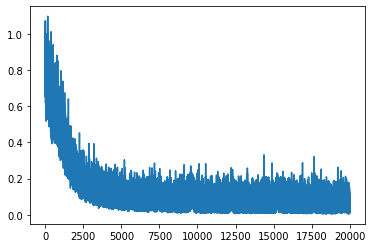

In [35]:
plt.plot(model.training_loss)

In [36]:
x1_test, X1_test = create_dataset(norm_solution, lags)

In [37]:
pred = np.zeros((len(norm_solution)-lags, X1_test.shape[-1]))
#pred = np.zeros((len(norm_solution)-lags, Y.shape[-1]))

X_tmp =  np.copy(x1_test[:,0:1,:])
for i in range(0, len(norm_solution)-lags):
  pred[i] = model.predict(X_tmp)
  X_tmp[:-1,:,:] = X_tmp[1:,:,:] 
  X_tmp[-1,:,:] = pred[i]   

In [39]:
np.linalg.norm(norm_solution[lags:][:,0] - pred[:,0])

78.09412451376593